In [4]:
import os
from nilearn.maskers import NiftiLabelsMasker
from nilearn import plotting
from nilearn.connectome import ConnectivityMeasure
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
parc_nii_path_seed = '/data/dzy/combined_method/AD/schaefer400x7_MNI.nii.gz'# Registered mask file
# bold_img_clean_masked_sm_path_seed = '/zebra/Brainmass/oasis_pro1/sub-OAS30001Vd0129S0_ses-1_task-rest_run-1_space-template_desc-preproc-1_bold.nii.gz' # Denoised and smoothed BOLD image
masker_seed = NiftiLabelsMasker(parc_nii_path_seed, standardize=True, verbose=0)  # Create a NiftiLabelsMasker object to extract ROI time series from fMRI data. Pass the ROI image path (parc_nii_path) and other options (standardize=True and verbose=0) to the constructor
# seed_timeseries = masker_seed.fit_transform(bold_img_clean_masked_sm_path_seed)
# pd.DataFrame(seed_timeseries).to_csv(os.path.join('sub-OAS30001Vd0129S0' + '_BOLD_' + 'schaefer400' + '.csv'))

In [5]:
input_dir = '/zebra/Brainmass/oasis_pro1'
output_dir = '/data/dzy/combined_method/AD/sourcedata/'
file_names = sorted([f for f in os.listdir(input_dir) if f.endswith('.nii.gz')])

In [ ]:
# Iterate through the sorted file list
for file_name in file_names:
    # Construct the complete file path
    bold_img_clean_masked_sm_path_seed = os.path.join(input_dir, file_name)
    
    # Extract the base filename (without path and extension)
    base_name = file_name.split('_')[0]
    
    # Extract time series
    seed_timeseries = masker_seed.fit_transform(bold_img_clean_masked_sm_path_seed)
    
    # Construct the output filename
    output_file_name = f"{base_name}_BOLD_schaefer400.csv"
    output_file_path = os.path.join(output_dir, output_file_name)
    
    # Save the time series as a CSV file
    pd.DataFrame(seed_timeseries).to_csv(output_file_path, index=False)

    print(f"Processed {file_name} and saved to {output_file_path}")

In [ ]:
import os
import shutil
import pandas as pd

# Define file paths
oasis_csv_path = '/data/dzy/combined_method/AD/oasis.csv'  # Path to oasis.csv file
sourcedata_path = '/data/dzy/combined_method/AD/sourcedata'  # Path to sourcedata folder
patient_path = '/data/dzy/combined_method/AD/normal'  # Path to normal folder (note: folder name remains as "normal" as per original code)

# Load the oasis.csv file
oasis_df = pd.read_csv(oasis_csv_path)

# Filter records where dx is "Cognitively normal"
ad_records = oasis_df[oasis_df['dx'] == 'Cognitively normal']

# Extract the prefix from old_name
prefixes = ad_records['old_name'].str.split('_ses-1_task-rest_run-1_space-template_desc-preproc-1_bold.nii.gz').str[0]

# Iterate through the sourcedata folder to find corresponding .csv files
for prefix in prefixes:
    source_file = os.path.join(sourcedata_path, f"{prefix}_BOLD_schaefer400.csv")
    if os.path.exists(source_file):
        # Copy the file to the normal folder
        shutil.copy(source_file, patient_path)
        print(f"Copied {source_file} to {patient_path}")
    else:
        print(f"No matching file found for {prefix}")

In [ ]:
import pandas as pd

file_path = '/data/dzy/combined_method/AD/OASIS3_amyloid_centiloid(1).csv'
df = pd.read_csv(file_path)
print(len(df))

In [ ]:
#PIB-RSD:16.4,AV45-RSF:20.6
filtered_df = df[
    ((df['tracer'] == 'AV45') & 
     (df['Centiloid_fSUVR_rsf_TOT_CORTMEAN'] < 20.6)) |
    ((df['tracer'] == 'PIB') & 
     (df['Centiloid_fSUVR_rsf_TOT_CORTMEAN'] < 16.4))
]
#Those greater than the threshold are positive ad

In [ ]:
new_file_path = '/data/dzy/combined_method/AD/OASIS3_amyloid_centiloid_hc.csv'
filtered_df.to_csv(new_file_path, index=False)
print(f"筛选完成，共找到 {len(filtered_df)} 条符合条件的记录。")

In [ ]:
import os

# Get the list of unique oasis_session_id from the filtered data
oasis_session_ids = filtered_df['oasis_session_id'].unique().tolist()

# Target folder path
target_folder = '/data/dzy/combined_method/AD/normal'

# Find matching filenames
matching_files = []
for filename in os.listdir(target_folder):
    # Check if the filename matches the pattern
    if filename.startswith('sub-') and '_BOLD_schaefer400.csv' in filename:
        # Extract the key part from the filename
        subject_part = filename.split('_')[0]  # Extract 'sub-OAS30593Vd4025S0'
        if 'V' in subject_part and 'S' in subject_part:
            # Extract the part before 'V' as oasis_id_part1
            oasis_id_part1 = subject_part.split('V')[0].replace('sub-', '')
            # Extract the part between 'V' and 'S' as oasis_id_part2
            oasis_id_part2 = subject_part.split('V')[1].split('S')[0]
            oasis_id_part3 = subject_part.rsplit('S', 1)[1]
#             print(oasis_id_part3)
            
            # Check for matching oasis_session_id
            for oasis_id in oasis_session_ids:
                parts = oasis_id.split('_')
                if len(parts) >= 3:
                    # Extract the corresponding parts from oasis_session_id
                    oasis_id_part1_check = parts[0]
                    oasis_id_part2_check = parts[2]
                    
                    # Consider the filename and oasis_session_id as matching if both parts align
                    if oasis_id_part1 == oasis_id_part1_check and oasis_id_part2 == oasis_id_part2_check:
                        matching_files.append((filename, oasis_id))
                        break
matching_files_sorted = sorted(matching_files, key=lambda x: x[0])

# 5. Output the sorted results
print(f"\n=== Matching Results (sorted by filename, total {len(matching_files_sorted)} files) ===")
if matching_files_sorted:
    for idx, (filename, oasis_id) in enumerate(matching_files_sorted, 1):
        print(f"{idx:2d}. Filename: {filename}  <-->  oasis_session_id: {oasis_id}")
else:
    print("❌ No matching files found.")
# # Output matching results
# if matching_files:
#     print(f"Found {len(matching_files)} matching files:")
#     for filename, oasis_id in matching_files:
#         print(f"Filename: {filename}  <-->  oasis_session_id: {oasis_id}")
# else:
#     print("No matching files found.")

In [ ]:
import os
import shutil
from pathlib import Path

target_dir = '/data/dzy/combined_method/AD/normal_amyloid_group/'

Path(target_dir).mkdir(parents=True, exist_ok=True)

# Extract matching filenames
matching_filenames = [filename for filename, _ in matching_files]

# Copy matching files to the target directory
copied_files = []
for filename in matching_filenames:
    source_path = os.path.join(target_folder, filename)
    target_path = os.path.join(target_dir, filename)
    
    try:
        shutil.copy2(source_path, target_path)
        copied_files.append(filename)
    except Exception as e:
        print(f"Failed to copy file {filename}: {e}")

# Output copy results
if copied_files:
    print(f"Successfully copied {len(copied_files)} files to {target_dir}")
    for file in copied_files:
        print(f"- {file}")
else:
    print("No files were copied.")

In [ ]:
import os
import csv
from pathlib import Path

def extract_matching_csv_rows(source_dirs, input_csv_path, output_csv_path):
    """
    Extract rows from the input CSV that match files in the source directories, and save to a new CSV file
    
    Parameters:
    source_dirs: List of directories containing source files
    input_csv_path: Path to the input CSV file
    output_csv_path: Path to the output CSV file
    """
    # Collect all OASISID and days_to_visit combinations from files
    file_id_day_pairs = set()
    
    # Iterate through each source directory
    for src_dir in source_dirs:
        # Check if the source directory exists
        if not os.path.exists(src_dir):
            print(f"Warning: Source directory does not exist - {src_dir}")
            continue
            
        # Get all CSV files in the current directory
        csv_files = [f for f in os.listdir(src_dir) if f.endswith('.csv')]
        
        # Parse each filename to extract OASISID and days part
        for file_name in csv_files:
            # Filename format: sub-OAS31465Vd0089S0_BOLD_schaefer400.csv
            prefix = 'sub-'
            if file_name.startswith(prefix):
                # Remove the prefix
                remaining = file_name[len(prefix):]
                # Split the Vd part
                if 'Vd' in remaining:
                    parts = remaining.split('Vd')
                    file_oasis_id = parts[0]
                    # Extract the days part (first 4 digits after Vd)
                    file_days = parts[1][:4]
                    
                    # Add to the set (automatically deduplicates)
                    file_id_day_pairs.add((file_oasis_id, file_days))
    print(file_id_day_pairs)
    print(f"Extracted {len(file_id_day_pairs)} unique ID-day combinations from source folders")
    
    # Read the input CSV and extract matching rows
    matched_rows = []
    fieldnames = None
    
    with open(input_csv_path, 'r') as infile:
        reader = csv.DictReader(infile)
        fieldnames = reader.fieldnames
        
        # Ensure the CSV contains required columns
        if 'OASISID' not in reader.fieldnames or 'days_to_visit' not in reader.fieldnames:
            raise ValueError("CSV file must contain 'OASISID' and 'days_to_visit' columns")
        
        for row in reader:
            oasis_id = row['OASISID'].strip()
            days = row['days_to_visit'].strip()
            # Format days as 4-digit number to match filenames
            days_formatted = days.zfill(4)
            
            # Check for matching combination
            if (oasis_id, days_formatted) in file_id_day_pairs:
                matched_rows.append(row)
    
    # Write matched rows to the output CSV
    with open(output_csv_path, 'w', newline='') as outfile:
        writer = csv.DictWriter(outfile, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(matched_rows)
    
    print(f"Operation completed. Extracted {len(matched_rows)} matching rows and saved to {output_csv_path}")

if __name__ == "__main__":
    # Modify the following paths according to actual conditions
    SOURCE_DIRS = [
        "/data/dzy/combined_method/AD/patient_amyloid_baseline",          # First source folder
        "/data/dzy/combined_method/AD/normal_amyloid_baseline"   # Second source folder
    ]
    INPUT_CSV_PATH = "/data/dzy/combined_method/AD/OASIS3_UDSd1_diagnoses.csv"  # Path to original CSV file
    OUTPUT_CSV_PATH = "/data/dzy/combined_method/AD/matched_rows_ad39_hc362.csv"       # Path to new CSV file for saving matched rows
    
    try:
        extract_matching_csv_rows(SOURCE_DIRS, INPUT_CSV_PATH, OUTPUT_CSV_PATH)
    except Exception as e:
        print(f"Error occurred: {str(e)}")
    

In [ ]:
import os
import csv
import re
from pathlib import Path

def extract_matching_by_oasisid(source_dirs, input_csv_path, output_csv_path, lower_bound=180, upper_bound=180):
    """
    Match by OASIS Subject and filter within a day range to find the closest match in the input CSV for each source file record.
    Ensure the number of output results matches the number of source file records, sorted by filename.
    Retain empty rows for unmatched records.
    """
    # Collect Subject, corresponding days, and filenames from source files (retain all records without merging)
    # Structure: [(subject, src_days, src_filename), ...]
    source_records = []
    
    # Extract Subject, days, and filenames from source files
    for src_dir in source_dirs:
        if not os.path.exists(src_dir):
            print(f"Warning: Source directory does not exist - {src_dir}")
            continue
        
        # Get all CSV files in the directory and sort by filename
        csv_files = sorted([f for f in os.listdir(src_dir) if f.endswith('.csv')])
        
        for file_name in csv_files:
            # Parse filename format: sub-OAS31465Vd0089S0_BOLD_schaefer400.csv
            match = re.match(r'sub-(OAS\d+)Vd(\d{4})', file_name)
            if not match:
                print(f"Skipping file with invalid format: {file_name}")
                continue
            
            subject = match.group(1)  # OAS31465
            days = int(match.group(2))  # 0089 -> 89
            source_records.append((subject, days, file_name))
    
    # Sort source records by filename (ensure final output order matches filename sort order)
    source_records.sort(key=lambda x: x[2])
    
    total_source = len(source_records)
    print(f"Extracted {total_source} records from source folders, corresponding to {len(set(r[0] for r in source_records))} unique Subjects")
    
    # Read input CSV and build index: {subject: [(input_days, row), ...]}
    input_data = {}
    with open(input_csv_path, 'r') as infile:
        reader = csv.DictReader(infile)
        fieldnames = reader.fieldnames
        
        required_cols = ['OASISID', 'days_to_visit']
        if not all(col in reader.fieldnames for col in required_cols):
            raise ValueError(f"CSV file must contain the following columns: {required_cols}")
        
        for row in reader:
            subject = row['OASISID'].strip()
            try:
                input_days = int(row['days_to_visit'].strip())
            except ValueError:
                print(f"Skipping row with invalid day format: Subject={subject}, days_to_visit={row['days_to_visit']}")
                continue
            
            if subject not in input_data:
                input_data[subject] = []
            input_data[subject].append((input_days, row))
    
    # Find the best match for each source record (ensure each source record has a corresponding output row)
    matched_rows = []
    missing_count = 0
    
    for (src_subject, src_days, src_filename) in source_records:
        # Create base row (contains source file info, other fields empty by default)
        base_row = {col: '' for col in fieldnames}
        base_row['source_filename'] = src_filename
        base_row['source_days'] = str(src_days)
        base_row['day_diff'] = ''
        
        # Check if the Subject exists in input data
        if src_subject not in input_data:
            print(f"Source record {src_filename} (Subject={src_subject}) has no matching Subject in input CSV, retaining empty row")
            matched_rows.append(base_row)
            missing_count += 1
            continue
        
        # Filter input records that meet the day range requirement
        valid_matches = []
        for (input_days, input_row) in input_data[src_subject]:
            day_diff = input_days - src_days
            if -lower_bound <= day_diff <= upper_bound:
                valid_matches.append((input_days, input_row, abs(day_diff)))
        
        if not valid_matches:
            print(f"Source record {src_filename} (Subject={src_subject}, Days={src_days}) has no eligible input records, retaining empty row")
            matched_rows.append(base_row)
            missing_count += 1
            continue
        
        # Select the input record with the smallest day difference
        valid_matches.sort(key=lambda x: x[2])
        best_match = valid_matches[0]
        print(f"Matched: Source File={src_filename}, Source Days={src_days}, Input Days={best_match[0]}, Day Difference={best_match[2]}")
        
        # Copy matched row and add source file info
        matched_row = best_match[1].copy()
        matched_row['source_filename'] = src_filename
        matched_row['source_days'] = str(src_days)
        matched_row['day_diff'] = str(best_match[2])
        matched_rows.append(matched_row)
    
    # Verify result count (should now always match)
    print(f"\nMatching completed: Total source records={total_source}, Successfully matched={total_source - missing_count}, Unmatched={missing_count}")
    if len(matched_rows) != total_source:
        print(f"Warning: Number of output records does not match source records ({len(matched_rows)} vs {total_source})")
    else:
        print(f"Number of output records matches source records ({len(matched_rows)} records)")
    
    # Write to output CSV (retain original columns + new source file info columns)
    new_fieldnames = fieldnames + ['source_filename', 'source_days', 'day_diff']
    with open(output_csv_path, 'w', newline='') as outfile:
        writer = csv.DictWriter(outfile, fieldnames=new_fieldnames)
        writer.writeheader()
        writer.writerows(matched_rows)
    
    print(f"Results saved to {output_csv_path}")

if __name__ == "__main__":
    SOURCE_DIRS = [
        "/data/dzy/combined_method/AD/patient_amyloid_group"
#         "/data/dzy/combined_method/AD/normal_amyloid_baseline"
    ]
    INPUT_CSV_PATH = "/data/dzy/combined_method/AD/OASIS3_UDSc1_cognitive_assessments.csv"
    OUTPUT_CSV_PATH = "/data/dzy/combined_method/AD/matched_rows_UDSc1_ad80.csv"
    LOWER_BOUND = 365  # Maximum forward days (input data can be earlier than source data by this number of days)
    UPPER_BOUND = 365  # Maximum backward days (input data can be later than source data by this number of days)
    
    try:
        extract_matching_by_oasisid(
            SOURCE_DIRS, 
            INPUT_CSV_PATH, 
            OUTPUT_CSV_PATH,
            lower_bound=LOWER_BOUND,
            upper_bound=UPPER_BOUND
        )
    except Exception as e:
        print(f"Error occurred: {str(e)}")


In [ ]:
import csv
import tempfile
import os
import shutil

def add_educ_to_matched_file(matched_csv_path, demographics_csv_path):
    """
    Add the EDUC column directly to the original matched file (fix cross-device link errors)
    
    Parameters:
        matched_csv_path: Path to the matched result CSV file to modify
        demographics_csv_path: Path to the demographics CSV file
    """
    # Read demographics data and build a mapping from OASISID to EDUC
    oasisid_to_educ = {}
    with open(demographics_csv_path, 'r', encoding='utf-8') as demo_file:
        demo_reader = csv.DictReader(demo_file)
        
        # Check if required columns exist
        if 'OASISID' not in demo_reader.fieldnames:
            raise ValueError("Demographics CSV file is missing the 'OASISID' column")
        if 'EDUC' not in demo_reader.fieldnames:
            raise ValueError("Demographics CSV file is missing the 'EDUC' column")
        
        for row in demo_reader:
            oasisid = row['OASISID'].strip()
            educ = row['EDUC'].strip()
            oasisid_to_educ[oasisid] = educ
    
    # Create a temporary file in the same directory as the target file to avoid cross-device issues
    temp_dir = os.path.dirname(matched_csv_path)
    with tempfile.NamedTemporaryFile(mode='w', newline='', encoding='utf-8', 
                                    delete=False, dir=temp_dir) as temp_file, \
         open(matched_csv_path, 'r', encoding='utf-8') as matched_file:
        
        matched_reader = csv.DictReader(matched_file)
        
        # Check if the matched file has the OASISID column
        if 'OASISID' not in matched_reader.fieldnames:
            raise ValueError("Matched result CSV file is missing the 'OASISID' column")
        
        # Replace the EDUC column if it already exists; otherwise, add it
        new_fieldnames = matched_reader.fieldnames
        if 'EDUC' not in new_fieldnames:
            new_fieldnames = new_fieldnames + ['EDUC']
        
        temp_writer = csv.DictWriter(temp_file, fieldnames=new_fieldnames)
        temp_writer.writeheader()
        
        # Process each row to add/update EDUC information
        for row in matched_reader:
            oasisid = row['OASISID'].strip() if row['OASISID'] else ''
            row['EDUC'] = oasisid_to_educ.get(oasisid, '')
            temp_writer.writerow(row)
    
    try:
        # First attempt to replace directly (succeeds when on the same device)
        os.replace(temp_file.name, matched_csv_path)
    except OSError:
        # Use copy + delete for cross-device scenarios
        shutil.copy2(temp_file.name, matched_csv_path)
        os.unlink(temp_file.name)
    
    print(f"Successfully added EDUC column to the original file: {matched_csv_path}")

if __name__ == "__main__":
    # File path configuration
    MATCHED_CSV = "/data/dzy/combined_method/AD/matched_rows_UDSc1_ad39_hc362.csv"
    DEMOGRAPHICS_CSV = "/data/dzy/combined_method/AD/OASIS3_demographics.csv"
    
    try:
        # It is recommended to back up the file first
        print(f"Warning: About to modify the original file {MATCHED_CSV}, please ensure you have a backup!")
        add_educ_to_matched_file(MATCHED_CSV, DEMOGRAPHICS_CSV)
    except Exception as e:
        print(f"Error occurred: {str(e)}")

In [ ]:
import os
import pandas as pd

# Replace with the actual correct folder paths
folder2 = 'normal_amyloid_baseline'
folder1 = 'patient_amyloid_baseline'

# Load the dataset
df = pd.read_csv('oasis.csv')

# Get all filenames in the two folders and sort them by filename
files_folder1 = sorted([f for f in os.listdir(folder1) if f.endswith('.csv')])
files_folder2 = sorted([f for f in os.listdir(folder2) if f.endswith('.csv')])

# Define a function to extract the key identifier from the filename
def extract_key(filename):
    return filename.split('_')[0]

# Create a new column to extract the key identifier from 'old_name' that matches the filename
df['key'] = df['old_name'].apply(extract_key)

# Create an empty DataFrame to store the matched data
new_df = pd.DataFrame()

# Iterate through files in the first folder in order
for file in files_folder1:
    key = extract_key(file)
    matched_rows = df[df['key'] == key]
    if not matched_rows.empty:
        matched_rows['folder_origin'] = folder1
        new_df = pd.concat([new_df, matched_rows], ignore_index=True)

# Iterate through files in the second folder in order
for file in files_folder2:
    key = extract_key(file)
    matched_rows = df[df['key'] == key]
    if not matched_rows.empty:
        matched_rows['folder_origin'] = folder2
        new_df = pd.concat([new_df, matched_rows], ignore_index=True)

# Save as a new CSV file
new_csv_path = 'oasis_amyloid_baseline.csv'
new_df.to_csv(new_csv_path, index=False)

In [ ]:
oasis_df = pd.read_csv('/data/dzy/combined_method/AD/matched_rows_UDSc1_ad39_hc362.csv')
# print(oasis_df)

In [ ]:
metrics = ['mentcont', 'asscmem', 'srttotal', 'bnt', 'simon','simonnumber', 'switch', 'slosson', 
           'udsbentc', 'udsbentd','udsvertn', 'udsverte', 'udsverti','minttots','mocatots']

columns = oasis_df.columns
for metric in columns: 
    cols_to_use = [ metric]
    df_subset1 = ad_records[cols_to_use].copy()
    df_subset1 = df_subset1.dropna() 

    print(f'{metric} - 样本量（{len(df_subset1)}个样本）')

In [ ]:
# ad_records = oasis_df[oasis_df['dx'] == 'Cognitively normal']
ad_records = oasis_df[oasis_df['dx'] == 'AD']
ad_records = ad_records.reset_index(drop=True)
# ad_records = ad_records.iloc[:,4:]
# print(ad_records)
dt = pd.read_csv('/data/dzy/combined_method/AD/EPLSA_amyloid/result_ad39_hc362/dwell_time.csv',sep = '\t')
AD_dt = dt[dt['condition'] == 'AD']
AD_dt = AD_dt.iloc[:,2:]
AD_dt = AD_dt.reset_index(drop=True) 
# print(AD_dt)
occ = pd.read_csv('/data/dzy/combined_method/AD/EPLSA_amyloid/result_ad39_hc362/Dynamics_20250622_16_28_08.csv',sep = ',')
AD_occ = occ[occ['condition'] == 'AD']
# AD_occ = AD_occ.loc[:,[' Frequency of B1',' Frequency of B2',' Frequency of B3',' Frequency of B4',
#                        ' Frequency of B5',' Frequency of B6']]
AD_occ = AD_occ.loc[:,[' Frequency of B3',' Frequency of B8']]
AD_occ = AD_occ.reset_index(drop=True)
occ_columns = AD_occ.columns
trans = pd.read_csv('/data/dzy/combined_method/AD/EPLSA_amyloid/result_ad39_hc362/transition_probabilities.csv',sep = '\t')
AD_trans = trans[trans['condition'] == 'AD']
# AD_occ = AD_occ.loc[:,['From_3_to_3','From_8_to_8']]
AD_trans = AD_trans.iloc[:,2:]
AD_trans = AD_trans.reset_index(drop=True)
# trans_columns = AD_trans.columns

# trans = pd.read_csv('/data/dzy/combined_method/AD/EMSA/RESULT/Transition.csv',sep = ',')
# AD_trans = trans[trans['condition'] == 'AD']
# AD_trans = AD_trans.loc[:,['Direct','Tran','Indirect']]
# AD_trans = AD_trans.reset_index(drop=True)
# trans_columns = AD_trans.columns
# fs = pd.read_csv('/data/dzy/combined_method/AD/EPLSA_baseline/result/FS7.csv',sep = ',')
# AD_fs = fs[fs['condition'] == 'AD']
# AD_fs = AD_fs.iloc[:,3:]
# AD_fs = AD_fs.reset_index(drop=True)
# fs_columns = AD_fs.columns

df = pd.concat([ad_records, AD_dt,AD_occ,AD_trans], axis=1)
df = df[(df['mmse'] > 0) & (df['mmse'] <= 23)]
# df = df.reset_index(drop=True)
df_columns = df.columns
print(df)
# selected_columns = df[['LOGIMEM', 'PL_state_1', 'PL_state_7']]
# selected_columns.to_csv('selected_columns.csv', index=False)

In [ ]:
import pingouin as pg
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr, kendalltau
# metrics = ['LOGIMEM']
columns = ['PL_state_8',' Frequency of B8','From_8_to_8','PL_state_3',' Frequency of B3','From_3_to_3']
metrics = ['mmse'] 
# metrics = ['mentcont', 'asscmem', 'srttotal', 'bnt', 'simon','simonnumber', 'switch', 'slosson', 
#            'udsbentc', 'udsbentd','udsvertn', 'udsverte', 'udsverti','minttots','mocatots']
# metrics = ['PSY019', 'PSY021', 'SIM', 'ANIMALS', 'VEG', 'mentcont', 'asscmem', 'srtfree', 'srttotal', 'digfor', 'digback', 'digsym', 'tma', 'tmb', 'bnt', 'LOGIMEM', 'MEMUNITS', 'lettnum', 'simon', 'simonnumber', 'switchCV', 'switchmixed', 'switch', 'inform', 'logmem', 'pairs', 'block', 'lmdelay', 'line', 'slosson', 'DIGIF', 'DIGIB', 'TRAILA', 'PSY003', 'udsbentc', 'udsbentd', 'udsbenrs', 'udsverfc', 'udsverfn', 'udsvernf', 'udsverlc', 'udsverlr', 'udsverln', 'udsvertn', 'udsverte', 'udsverti', 'craftvrs', 'crafturs', 'craftdvr', 'craftdre', 'craftdti', 'craftcue', 'minttots', 'minttotw', 'mintscng', 'mintscnc', 'mintpcng', 'mintpcnc', 'digforct', 'digforsl', 'digbacct', 'digbacls', 'place_r', 'numsym', 'mocacomp', 'mocareas', 'mocaloc', 'mocalan', 'mocalanx', 'mocavis', 'mocahear', 'mocatots', 'mocatrai', 'mocacube', 'mocacloc', 'mocaclon', 'mocacloh', 'mocanami', 'mocaregi', 'mocadigi', 'mocalett', 'mocaser7', 'mocarepe', 'mocaflue', 'mocaabst', 'mocarecn', 'mocarecc', 'mocarecr', 'mocaordt', 'mocaormo', 'mocaoryr', 'mocaordy', 'mocaorpl', 'mocaorct', 'trigram', 'spatial', 'trailb', 'srt1f', 'srt1c', 'srt2f', 'srt2c', 'srt3f', 'srt3c']
for occ_col in columns:
    for metric in metrics: 
        cols_to_use = [occ_col, metric, 'age', 'sex','EDUC']
        df_subset1 = df[cols_to_use].copy()
        df_subset1 = df_subset1.dropna()  # Remove rows containing missing values
        print(f'{metric} - Sample size ({len(df_subset1)} samples)')
        # Check if sample size is sufficient
        if len(df_subset1) < 10:
            print(f'ad:{occ_col}vs{metric} - Insufficient sample size ({len(df_subset1)} samples), skipping analysis')
            continue
        
        # Perform partial correlation analysis
        result1 = pg.partial_corr(data=df_subset1, x=occ_col, y=metric, covar=['age', 'EDUC'])
        r1 = result1['r'].values[0]
        p1 = result1['p-val'].values[0]
        
        # Perform Spearman correlation analysis
        r11, p11 = spearmanr(df_subset1[occ_col], df_subset1[metric])
        
        print(f'ad:{occ_col}vs{metric}')
        print(f'spearmanr: r={r11:.4f}, p={p11:.4f}; Partial correlation: r={r1:.4f}, p={p1:.6f}')
        
        # If Spearman correlation is significant, plot scatter plot
        if p1 < 0.05: 
            plt.figure(figsize=(8, 6))
            sns.scatterplot(data=df_subset1, x=occ_col, y=metric, color="#1B9E77")
            sns.regplot(x=occ_col, y=metric, data=df_subset1, scatter=False, color="#1B9E77")
            plt.xlabel(f'{occ_col} in AD', fontsize=15)
            plt.ylabel(metric, fontsize=15)
            plt.tick_params(axis='both', labelsize=12)
#             filename = f'{occ_col}_vs_{metric}.png'
#             plt.savefig(f"/data/dzy/combined_method/AD/EPLSA_amyloid/result_ad291_hc362/significant_corr/{filename}", dpi=300, bbox_inches='tight')
        plt.show()

In [ ]:
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr

metrics = ['PSY019', 'PSY021', 'SIM', 'ANIMALS', 'VEG', 'mentcont', 'asscmem', 'srtfree', 'srttotal', 'digfor', 'digback', 'digsym', 'tma', 'tmb', 'bnt', 'LOGIMEM', 'MEMUNITS', 'lettnum', 'simon', 'simonnumber', 'switchCV', 'switchmixed', 'switch', 'inform', 'logmem', 'pairs', 'block', 'lmdelay', 'line', 'slosson', 'DIGIF', 'DIGIB', 'TRAILA', 'PSY003', 'udsbentc', 'udsbentd', 'udsbenrs', 'udsverfc', 'udsverfn', 'udsvernf', 'udsverlc', 'udsverlr', 'udsverln', 'udsvertn', 'udsverte', 'udsverti', 'craftvrs', 'crafturs', 'craftdvr', 'craftdre', 'craftdti', 'craftcue', 'minttots', 'minttotw', 'mintscng', 'mintscnc', 'mintpcng', 'mintpcnc', 'digforct', 'digforsl', 'digbacct', 'digbacls', 'place_r', 'numsym', 'mocacomp', 'mocareas', 'mocaloc', 'mocalan', 'mocalanx', 'mocavis', 'mocahear', 'mocatots', 'mocatrai', 'mocacube', 'mocacloc', 'mocaclon', 'mocacloh', 'mocanami', 'mocaregi', 'mocadigi', 'mocalett', 'mocaser7', 'mocarepe', 'mocaflue', 'mocaabst', 'mocarecn', 'mocarecc', 'mocarecr', 'mocaordt', 'mocaormo', 'mocaoryr', 'mocaordy', 'mocaorpl', 'mocaorct', 'trigram', 'spatial', 'trailb', 'srt1f', 'srt1c', 'srt2f', 'srt2c', 'srt3f', 'srt3c']

def remove_outliers(df, cols, method='iqr', z_threshold=3):
    """
    Remove outliers from the DataFrame
    
    Parameters:
    df: Input DataFrame
    cols: List of column names to check for outliers
    method: Outlier detection method ('iqr' or 'zscore')
    z_threshold: Threshold for Z-score method, default is 3
    
    Returns:
    DataFrame with outliers removed
    """
    df_clean = df.copy()
    
    for col in cols:
        if method == 'iqr':
            # IQR method
            q1 = df_clean[col].quantile(0.25)
            q3 = df_clean[col].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
        elif method == 'zscore':
            # Z-score method
            z_scores = np.abs((df_clean[col] - df_clean[col].mean()) / df_clean[col].std())
            df_clean = df_clean[z_scores <= z_threshold]
        else:
            raise ValueError("Method must be either 'iqr' or 'zscore'")
    
    return df_clean

for occ_col in dt_columns:
    for metric in metrics: 
        cols_to_use = [occ_col, metric, 'age', 'EDUC']
        df_subset1 = df[cols_to_use].copy()
        df_subset1 = df_subset1.dropna()  # First remove missing values
        
        # Record original sample size
        original_count = len(df_subset1)
        
        # If sample size is sufficient, perform outlier removal
        if original_count >= 3:
            # Remove outliers from the two variables being analyzed
            df_clean = remove_outliers(df_subset1, [occ_col, metric], method='zscore')
            cleaned_count = len(df_clean)
            
            # Check sample size after outlier removal
            if cleaned_count < 3:
                print(f'ad:{occ_col}vs{metric} - Insufficient sample size after outlier removal ({cleaned_count} samples), skipping analysis')
                continue
            elif cleaned_count < original_count:
                print(f'ad:{occ_col}vs{metric} - Removed {original_count - cleaned_count} outliers, remaining {cleaned_count} samples')
        else:
            print(f'ad:{occ_col}vs{metric} - Insufficient original sample size ({original_count} samples), skipping analysis')
            continue
        
        # Perform partial correlation analysis
        result1 = pg.partial_corr(data=df_clean, x=occ_col, y=metric, covar=['age'])
        r1 = result1['r'].values[0]
        p1 = result1['p-val'].values[0]
        
        # Perform Spearman correlation analysis
        r11, p11 = spearmanr(df_clean[occ_col], df_clean[metric])
        
        print(f'ad:{occ_col}vs{metric}')
        print(f'spearmanr: r={r11:.4f}, p={p11:.4f}; Partial correlation: r={r1:.4f}, p={p1:.4f}')
        
        # If Spearman correlation is significant, plot scatter plot
        if p1 < 0.05: 
            plt.figure(figsize=(8, 6))
            sns.scatterplot(data=df_clean, x=occ_col, y=metric, color="#1B9E77")
            sns.regplot(x=occ_col, y=metric, data=df_clean, scatter=False, color="#1B9E77")
            plt.xlabel(f'{occ_col} in AD', fontsize=15)
            plt.ylabel(metric, fontsize=15)
#             plt.title(f'n={cleaned_count} (Removed {original_count - cleaned_count} outliers)')
            plt.tick_params(axis='both', labelsize=12)
            plt.show()

             P
0     0.283951
1     0.209877
2     0.209877
3     0.265432
4     0.172840
...        ...
2171  0.351852
2172  0.054054
2173  0.222222
2174  0.222222
2175  0.358025

[2176 rows x 1 columns]


findfont: Font family 'Lobster Two' not found.
findfont: Font family 'Lobster Two' not found.
findfont: Font family 'Lobster Two' not found.
findfont: Font family 'Lobster Two' not found.
findfont: Font family 'Lobster Two' not found.
findfont: Font family 'Lobster Two' not found.
findfont: Font family 'Lobster Two' not found.


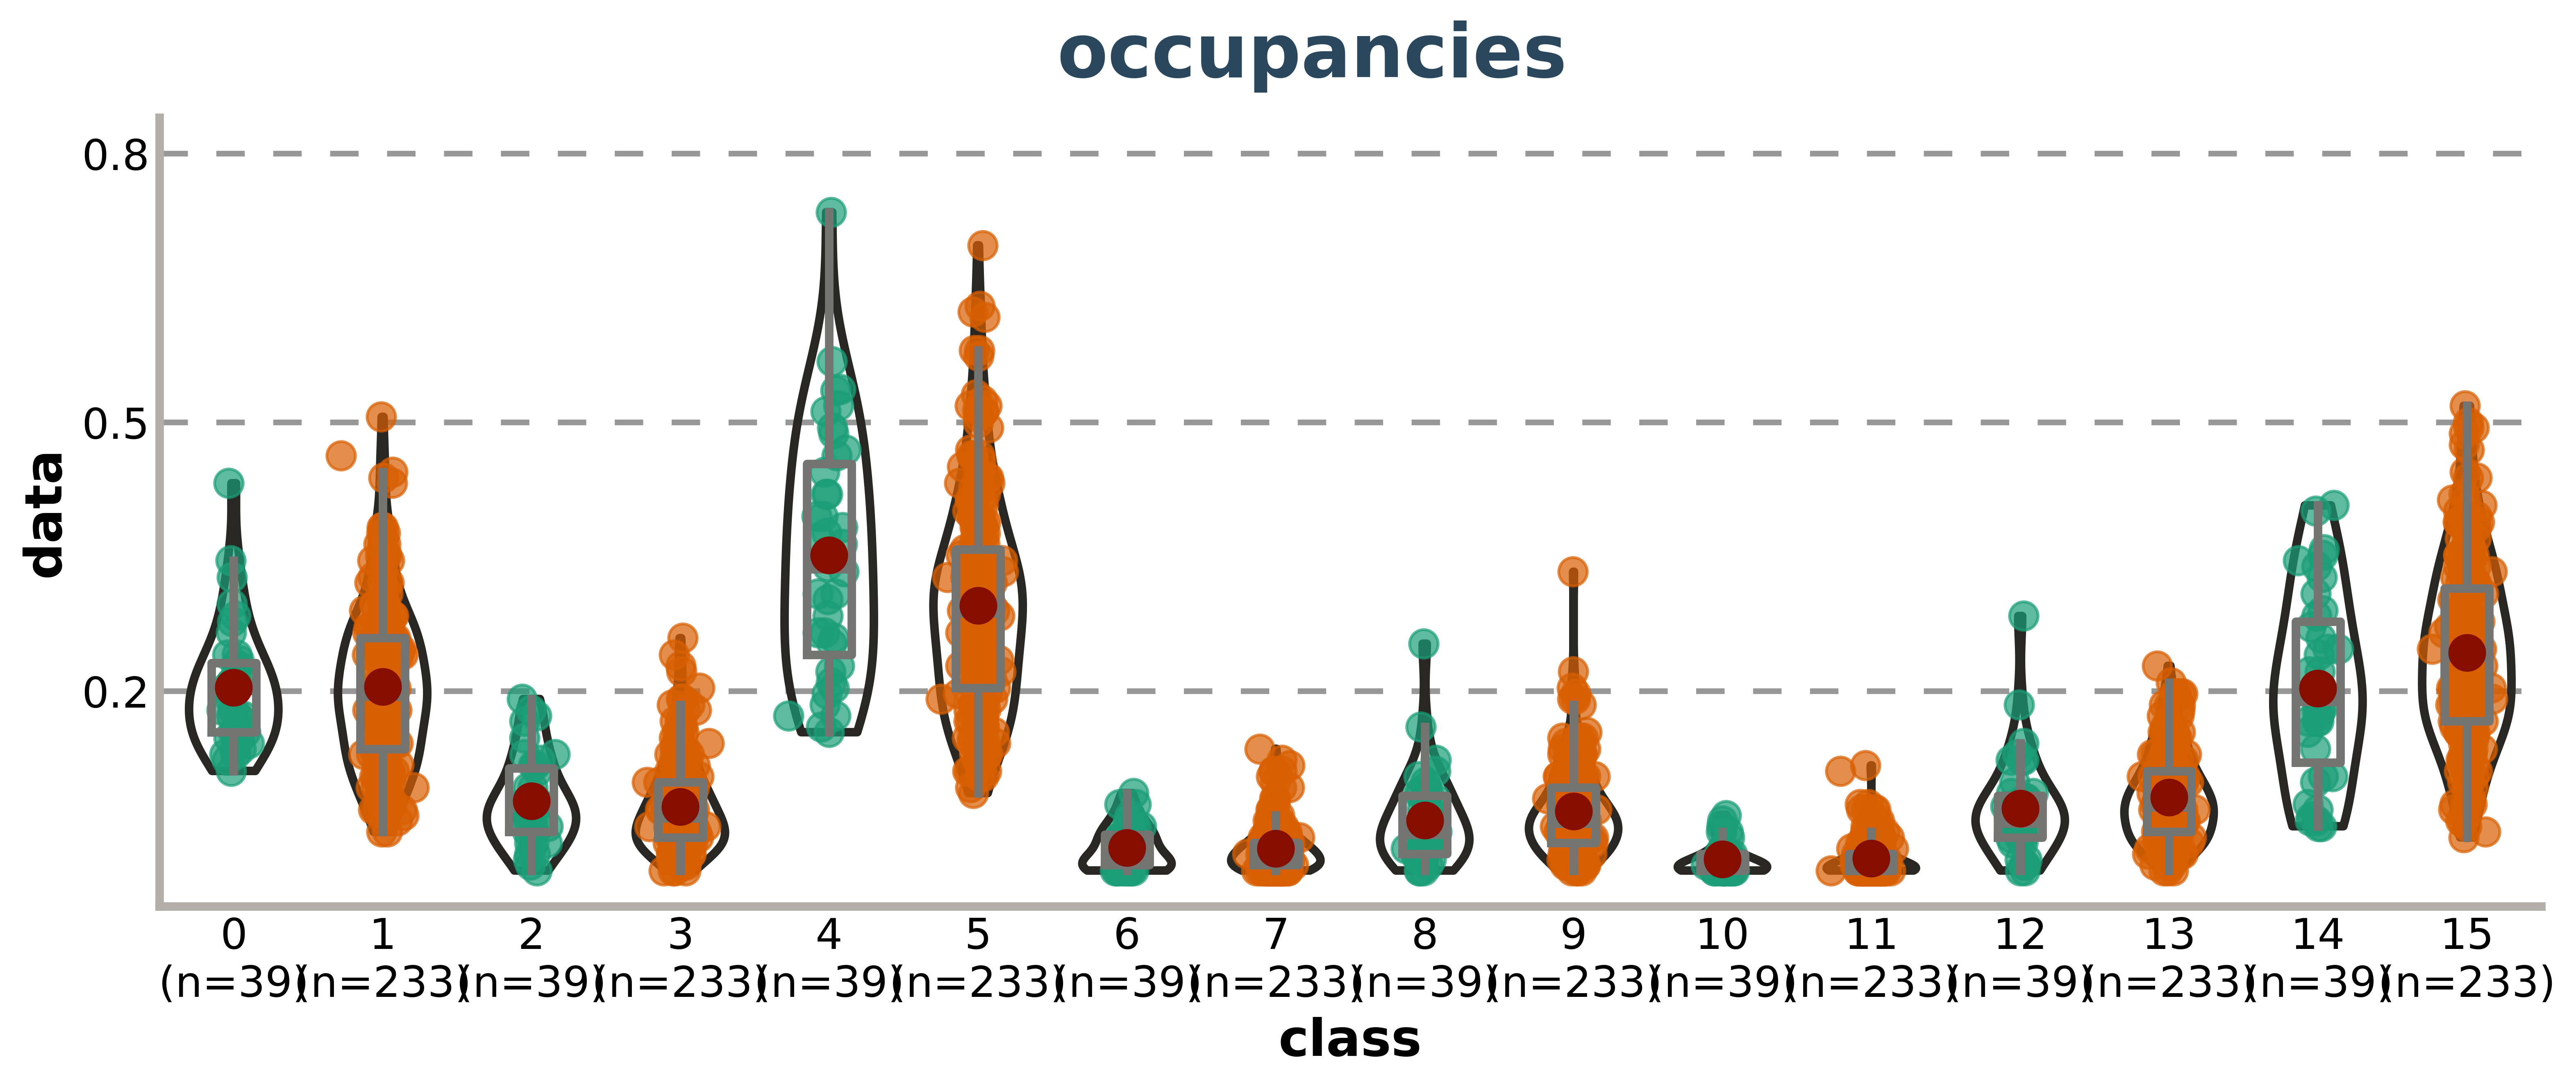

In [ ]:
import scipy.stats as st
result_path = f'/data/dzy/combined_method/AD/EPLSA_amyloid/result_ad39_hc362/Dynamics_20250622_16_28_08_new.csv'
# result_path = f'/data/dzy/combined_method/AD/EPLSA_baseline/result/Dynamics_20250615_13_55_48.csv'
# occ_combined_method['condition'] = occ_combined_method['condition'].replace({'N1': 'Sleep', 'N2': 'Sleep','N3':'Sleep'})
scl1 = pd.read_csv(result_path,sep=',')
scl1 = scl1.dropna(subset=['dx'])
# scl1 = scl1.loc[:,[' Frequency of B3','major2',' Frequency of B1',' Frequency of B4',' Frequency of B2']]
# scl1 = scl1.loc[:,[' Frequency of B1',' Frequency of B2',' Frequency of B3',' Frequency of B4',' Frequency of B5',' Frequency of B6']]
# scl1 = scl1.loc[:,['major_occ','minor_occ']]
scl1 = scl1.drop(scl1.columns[0:2], axis=1)
scl1 = scl1.iloc[:, :-1]
# print(scl1)
scl1 = scl1.astype(float)

###200_400
pp = [None] * 272 * 8
pp[0:39] = scl1.iloc[0:39,0]
pp[39:272] = scl1.iloc[39:272,0]

pp[272:311] = scl1.iloc[0:39,1]
pp[311:544] = scl1.iloc[39:272,1]

pp[544:583] = scl1.iloc[0:39,2]
pp[583:816] = scl1.iloc[39:272,2]

pp[816:855] = scl1.iloc[0:39,3]
pp[855:1088] = scl1.iloc[39:272,3]

pp[1088:1127] = scl1.iloc[0:39,4]
pp[1127:1360] = scl1.iloc[39:272,4]

pp[1360:1399] = scl1.iloc[0:39,5]
pp[1399:1632] = scl1.iloc[39:272,5]

pp[1632:1671] = scl1.iloc[0:39,6]
pp[1671:1904] = scl1.iloc[39:272,6]

pp[1904:1943] = scl1.iloc[0:39,7]
pp[1943:2176] = scl1.iloc[39:272,7]

data = pd.DataFrame(pp,columns=['P'])
print(data)
group = []


for i in range(39):
    group.append(0)
for i in range(39,272):
    group.append(1)
for i in range(272,311):
    group.append(2)
for i in range(311,544):
    group.append(3)
for i in range(544,583):
    group.append(4)
for i in range(583,816):
    group.append(5)
for i in range(816,855):
    group.append(6)
for i in range(855,1088):
    group.append(7)
for i in range(1088,1127):
    group.append(8)
for i in range(1127,1360):
    group.append(9)
for i in range(1360,1399):
    group.append(10)
for i in range(1399,1632):
    group.append(11)
for i in range(1632,1671):
    group.append(12)
for i in range(1671,1904):
    group.append(13)
for i in range(1904,1943):
    group.append(14)
for i in range(1943,2176):
    group.append(15)
    
data['group']=group
# print(data)


classes = sorted(data["group"].unique())  

y_data = [data[data["group"] == c]["P"].values for c in classes] 


jitter = 0.04
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + st.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]
 
BG_WHITE = "w"
GREY_LIGHT = "#b4aea9"
GREY50 = "#7F7F7F"
BLUE_DARK = "#1B2838"
BLUE = "#2a475e"
BLACK = "#282724"
GREY_DARK = "#747473"
RED_DARK = "#850e00"
COLOR_SCALE = ["#1B9E77",
               "#D95F02",
               "#1B9E77",
               "#D95F02",
               "#1B9E77",
               "#D95F02",
               "#1B9E77",
               "#D95F02",
               "#1B9E77",
               "#D95F02",
               "#1B9E77",
               "#D95F02",
               "#1B9E77",
               "#D95F02",
               "#1B9E77",
               "#D95F02"] 

POSITIONS = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
#,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
HLINES = [0.2,0.5,0.8]#occ
# HLINES = [-0.9,0,0.9]
 
fig, ax = plt.subplots(figsize=(15, 5), dpi=500)
 
# Set layout ----------------------------------------------
# Background color
fig.patch.set_facecolor(BG_WHITE)
ax.set_facecolor(BG_WHITE)
 
# Horizontal lines for scale reference
for h in HLINES:
    ax.axhline(h, color=GREY50, ls=(0, (5, 5)), alpha=0.8, zorder=0, linewidth=2)
 
# Add violin plots ----------------------------------------------------
# bw_method="silverman" means the bandwidth for kernel density estimation is calculated using Silverman's rule
 
# Output stored in 'violins' for customizing their appearance
violins = ax.violinplot(
    y_data,
    positions=POSITIONS,
    widths=0.6,
    bw_method="silverman",
    showmeans=False,
    showmedians=False,
    showextrema=False
)
 
# Customize violin plots (remove fill, customize lines, etc.)
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor(BLACK)
    pc.set_linewidth(3)
    pc.set_alpha(1)
 
# Add box plots ---------------------------------------------------
# Note: Attributes for median and box are passed as dictionaries.
 
medianprops = dict(
    linewidth=5,
    color=GREY_DARK,
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=3,
    color=GREY_DARK
)
 
ax.boxplot(
    y_data,
    positions=POSITIONS,
    showfliers=False,  # Do not show outliers beyond the top and bottom of the box
    showcaps=False,  # Do not show box top and bottom caps
    medianprops=medianprops,
    whiskerprops=boxprops,
    boxprops=boxprops,
    widths=0.3
)
 
# Add jittered points ----------------------------------------------
for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
    ax.scatter(x, y, s=100, color=color, alpha=0.7)
# Add mean value labels  ------------------------------------------
means = [y.mean() for y in y_data]
for i, mean in enumerate(means):
    # Add points representing mean values
    ax.scatter(i, mean, s=150, color=RED_DARK, zorder=3)
 
# Customize layout -----------------------------------------------
# Hide axes
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")
 
# Customize axis colors
ax.spines["left"].set_color(GREY_LIGHT)
ax.spines["left"].set_linewidth(3)
ax.spines["bottom"].set_color(GREY_LIGHT)
ax.spines["bottom"].set_linewidth(3)
 
# Customize labels and ticks
ax.tick_params(length=0)
ax.set_yticks(HLINES)
ax.set_yticklabels(HLINES, size=15)
ax.set_ylabel("data", size=18, weight="bold")
 
# X-axis labels include sample size for each class
xlabels = [f"{classes}\n(n={y_data[i].size})" for i, classes in enumerate(classes)]
ax.set_xticks(POSITIONS)
ax.set_xticklabels(xlabels, size=15, ha="center", ma="center")
ax.set_xlabel("class", size=18, weight="bold")
 
fig.suptitle(
    "occupancies",
#     "transitions",
    x = 0.5,
    y = 0.975,
    ha="center",
    fontsize=26,
    fontname="Lobster Two",
    color=BLUE,
    weight="bold",
)
plt.savefig(r"/data/dzy/combined_method/AD/EPLSA_amyloid/result_ad39_hc362/occ_new.png", dpi=500) 
# plt.savefig(r"/data/dzy/bids_INV2/derivatives/brainstate/figure/dwell_time.png", dpi=500) 
plt.show()